In [15]:
suppressMessages(library(Signac))
suppressMessages(library(Seurat))
suppressMessages(library(GenomeInfoDb))
suppressMessages(library(ggplot2))
suppressMessages(library(RColorBrewer))

suppressMessages(library(tidyverse))
set.seed(1234)
suppressMessages(library(data.table))
suppressMessages(library(TFBSTools))
suppressMessages(library(ChIPseeker))
suppressMessages(library(TxDb.Hsapiens.UCSC.hg38.knownGene))
library(readxl)
library(UpSetR)
library(grid)

In [2]:
colors <- readRDS('/diskmnt/Projects/snATAC_primary/PanCan_ATAC_data_freeze/v7.0/Colors_panatac_v2.0.rds')
colors

$cell_type
                               Doublet                                  Tumor 
                                "grey"                              "#e7298a" 
                           Fibroblasts                              Pericytes 
                             "#d95f02"                              "#ff7f00" 
                           Endothelial                Normal epithelial cells 
                             "#66a61e"                              "#1b9e77" 
                           Macrophages                                   Mast 
                             "#7570b3"                              "#6a3d9a" 
                               T-cells                                     NK 
                             "#1f78b4"                              "#a6cee3" 
                                 Tregs                                 Plasma 
                             "#b3cde3"                              "#fb9a99" 
                               B-cells                         B-cells/Plasma 
                             "#e31a1c"                              "#cb181d" 
                                    DC                       Oligodendrocytes 
                             "#cab2d6"                              "#33a02c" 
                               Neurons                                    OPC 
                             "#b2df8a"                              "#fccde5" 
                          Erythrocytes                            Hepatocytes 
                             "#fbb4ae"                              "#a65628" 
                            Epithelial                               Alveolar 
                             "#1b9e77"                              "#b3cde3" 
                                Goblet                                 Acinar 
                             "#fed9a6"                              "#e78ac3" 
                                Islets                                Unknown 
                             "#7fc97f"                                 "grey" 
                        Cholangiocytes                             Astrocytes 
                             "#ffd92f"                              "#e78ac3" 
                             Microglia Secretory Endometrial epithelial cells 
                             "#8da0cb"                              "#a6761d" 
 Ciliated Endometrial epithelial cells                         Luminal mature 
                             "#e6ab02"                              "#005824" 
                    Luminal progenitor                       Basal progenitor 
                             "#41ae76"                              "#99d8c9" 
                               Unknown                         Cholangiocytes 
                                "grey"                              "#ffd92f" 
                            Astrocytes                              Microglia 
                             "#e78ac3"                              "#8da0cb" 
                               Unknown                         Cholangiocytes 
                                "grey"                              "#ffd92f" 
                            Astrocytes                              Microglia 
                             "#e78ac3"                              "#8da0cb" 

$Cancer
      BRCA BRCA_Basal       CESC        CRC      ccRCC        GBM         MM 
 "#fb9a99"  "#e31a1c"  "#fdbf6f"  "#ff7f00"  "#cab2d6"  "#6a3d9a"  "#b15928" 
     HNSCC         OV       PDAC       UCEC       SKCM 
 "#b2df8a"  "#33a02c"  "#a6cee3"  "#1f78b4"  "#c9b92e"

In [5]:
## Load links annotated by 1_Annotate_links_by_enhancers_geneHancerInter_filter_diffuse_DACRs.ipynb
all.links <- fread('/diskmnt/Projects/snATAC_analysis/tumor_Alla/linkingGenes_v7.0/annotate.links/tumor_only_multiome/Pancan_all.links.filtered_by_zscore_diffused_links_annotated_by_GeneHancer_EpiMap_ENCODE_with_CNV_DAP_DEG_met.txt')
all.links %>% head()

Cancer,gene,peak,seqnames,start,end,width,strand,score,zscore,⋯,Enhancer_gene_pair,Enhancer_gene_pair.in.genehancerInter,Peak.to.gene,cnv,N.cells.with.cnv,cnv.pct,DAP.tumor,DEG.tumor,DAP.met,DEG.met
<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,⋯,<chr>,<lgl>,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>
BRCA,A1CF,chr10-50849652-50850152,chr10,50849902,50885675,35774,*,0.05668379,9.042230,⋯,NA:A1CF,FALSE,chr10-50849652-50850152:A1CF,,NA,NA,Not tested,Not tested,Not tested,Not tested
BRCA,A1CF,chr10-50862595-50863095,chr10,50862845,50885675,22831,*,0.10822264,17.177156,⋯,NA:A1CF,FALSE,chr10-50862595-50863095:A1CF,,NA,NA,Not tested,Not tested,Not tested,Not tested
BRCA,A2M,chr12-8642827-8643327,chr12,8643077,9116229,473153,*,0.12892541,8.851513,⋯,NA:A2M,FALSE,chr12-8642827-8643327:A2M,Gain,10488,0.2101425,Not tested,Not tested,Not tested,Not tested
BRCA,A2M,chr12-8642827-8643327,chr12,8643077,9116229,473153,*,0.12892541,8.851513,⋯,NA:A2M,FALSE,chr12-8642827-8643327:A2M,Loss,6362,0.1274720,Not tested,Not tested,Not tested,Not tested
BRCA,A2M,chr12-8687697-8688197,chr12,8687947,9116229,428283,*,0.08111414,6.373127,⋯,GH12J008687:A2M,FALSE,chr12-8687697-8688197:A2M,Gain,10488,0.2101425,Not tested,Not tested,Not tested,Not tested
BRCA,A2M,chr12-8687697-8688197,chr12,8687947,9116229,428283,*,0.08111414,6.373127,⋯,GH12J008687:A2M,FALSE,chr12-8687697-8688197:A2M,Loss,6362,0.1274720,Not tested,Not tested,Not tested,Not tested


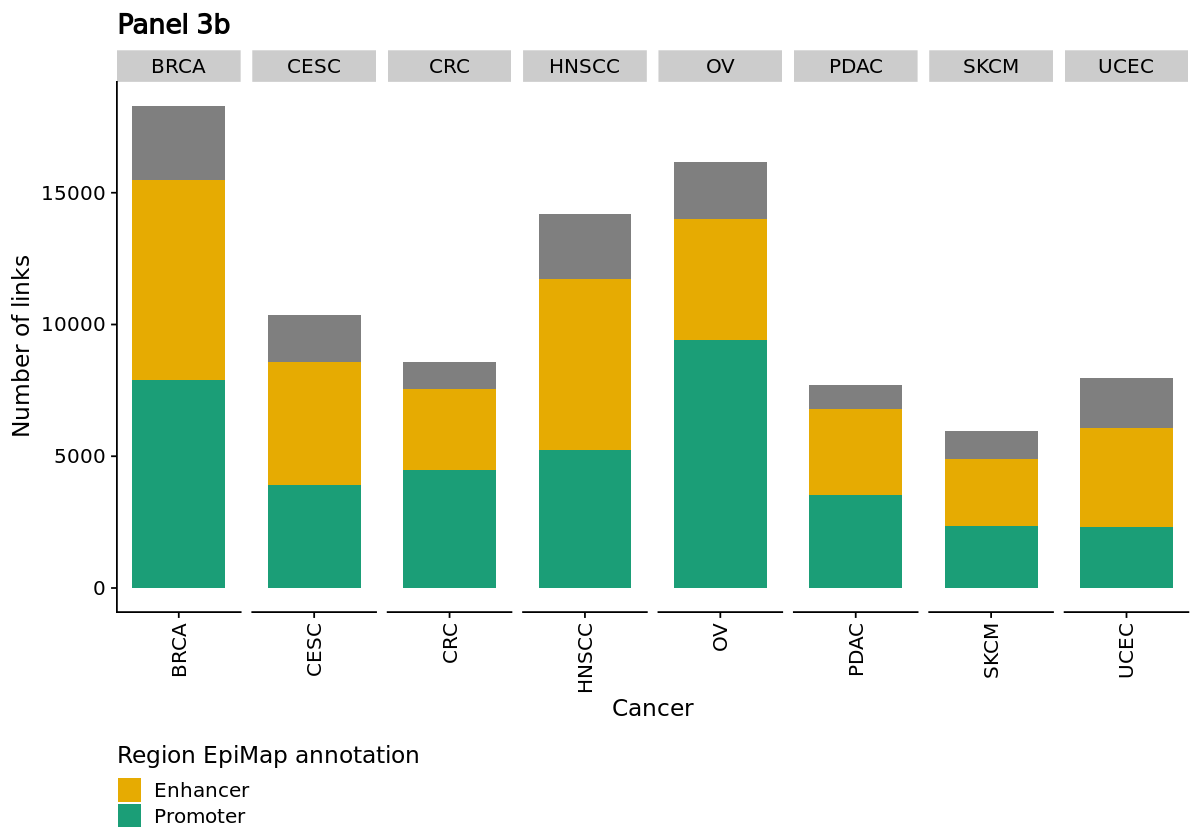

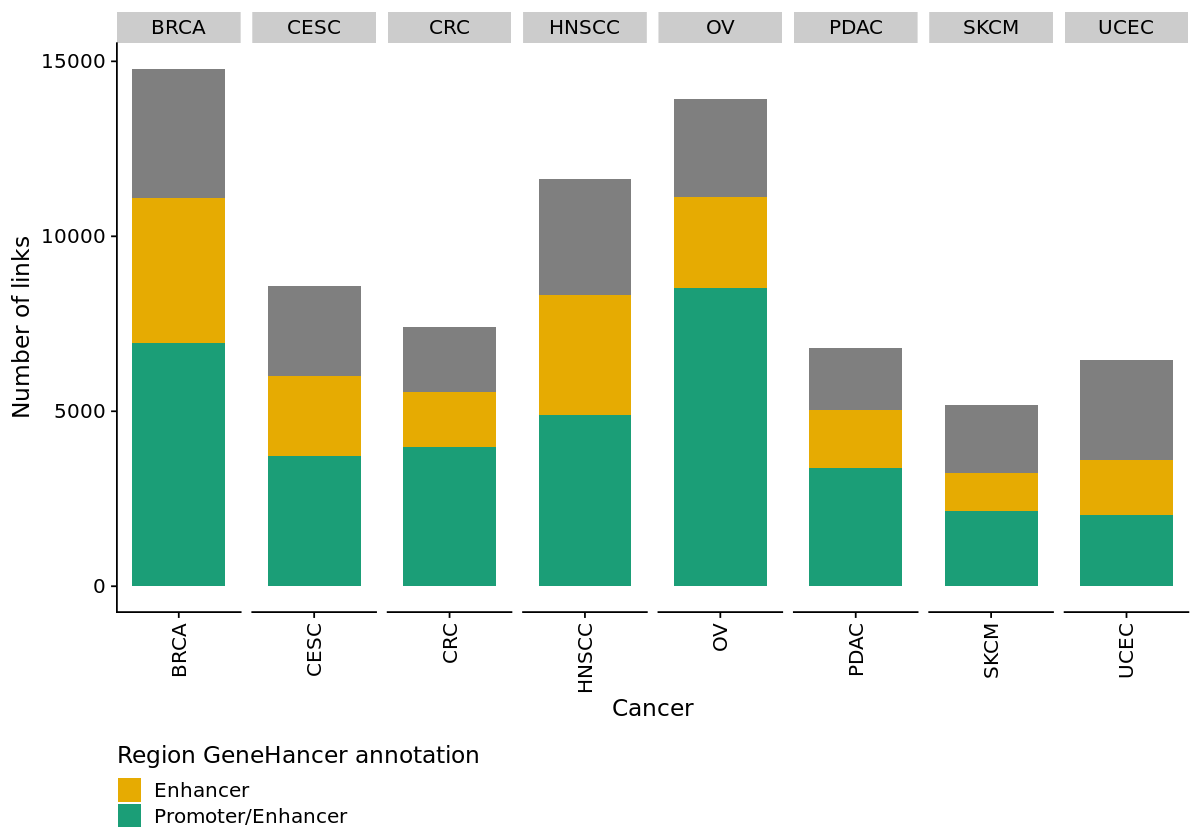

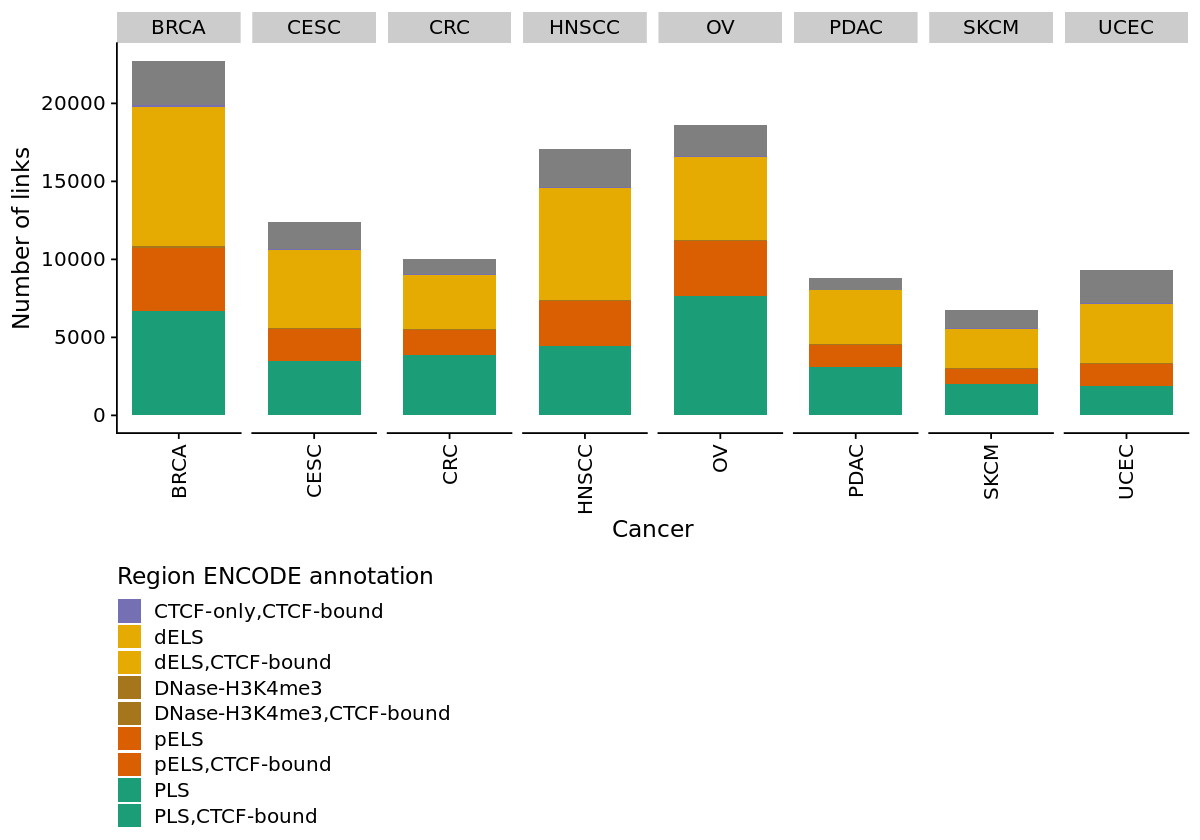

In [13]:
#this is panel 3b
toplot <- all.links %>%
    filter(!(paste(gene, Cancer, sep ='_') %in% genes.gained)) %>% 
    dplyr::select(EpiMap.Annotation, Cancer,Enhancer_gene_pair) %>% 
    distinct() %>%
    group_by(EpiMap.Annotation, Cancer) %>% 
    tally()

options(repr.plot.width=10, repr.plot.height=7)
ggplot(toplot, aes(x= Cancer, y = n, fill = EpiMap.Annotation)) +
    geom_bar(stat = 'identity') +
    facet_grid(~Cancer, scales = 'free') +
    scale_fill_manual (values = c('Promoter' = '#1b9e77', Enhancer = '#e6ab02'), name = 'Region EpiMap annotation') +
    cowplot::theme_cowplot() +
    ylab('Number of links') +
    theme(legend.position="bottom", 
            axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5),
         legend.direction = "vertical") +
    ggtitle('Panel 3b')

#other databases not included in the paper
toplot <- all.links %>%
    filter(!(paste(gene, Cancer, sep ='_') %in% genes.gained)) %>% 
    dplyr::select(GeneHancer.Annotation, Cancer,Enhancer_gene_pair) %>% 
    distinct() %>%
    group_by(GeneHancer.Annotation, Cancer) %>% 
    tally()

options(repr.plot.width=10, repr.plot.height=7)
ggplot(toplot, aes(x= Cancer, y = n, fill = GeneHancer.Annotation)) +
    geom_bar(stat = 'identity') +
    facet_grid(~Cancer, scales = 'free') +
    scale_fill_manual (values = c('Promoter/Enhancer' = '#1b9e77', Enhancer = '#e6ab02'), name = 'Region GeneHancer annotation') +
    cowplot::theme_cowplot() +
    ylab('Number of links') +
    theme(legend.position="bottom", 
            axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5),
         legend.direction = "vertical") 

toplot <- all.links %>%
    filter(!(paste(gene, Cancer, sep ='_') %in% genes.gained)) %>% 
    dplyr::select(ENCODE.Annotation, Cancer,Enhancer_gene_pair) %>% 
    distinct() %>%
    group_by(ENCODE.Annotation, Cancer) %>% 
    tally()

options(repr.plot.width=10, repr.plot.height=7)
ggplot(toplot, aes(x= Cancer, y = n, fill = ENCODE.Annotation)) +
    geom_bar(stat = 'identity') +
    facet_grid(~Cancer, scales = 'free') +
    scale_fill_manual (values =  c('PLS' = '#1b9e77',
                                                      'PLS,CTCF-bound' = '#1b9e77',
                                                      'dELS' = '#e6ab02',
                                                      'dELS,CTCF-bound' = '#e6ab02',
                                                      'pELS' = '#d95f02',
                                                      'pELS,CTCF-bound' = '#d95f02',
                                                     'CTCF-only,CTCF-bound' = '#7570b3',
                                                     'DNase-H3K4me3' = '#a6761d',
                                                     'DNase-H3K4me3,CTCF-bound' = '#a6761d'), 
                       name = 'Region ENCODE annotation') +
    cowplot::theme_cowplot() +
    ylab('Number of links') +
    theme(legend.position="bottom", 
            axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5),
         legend.direction = "vertical") 



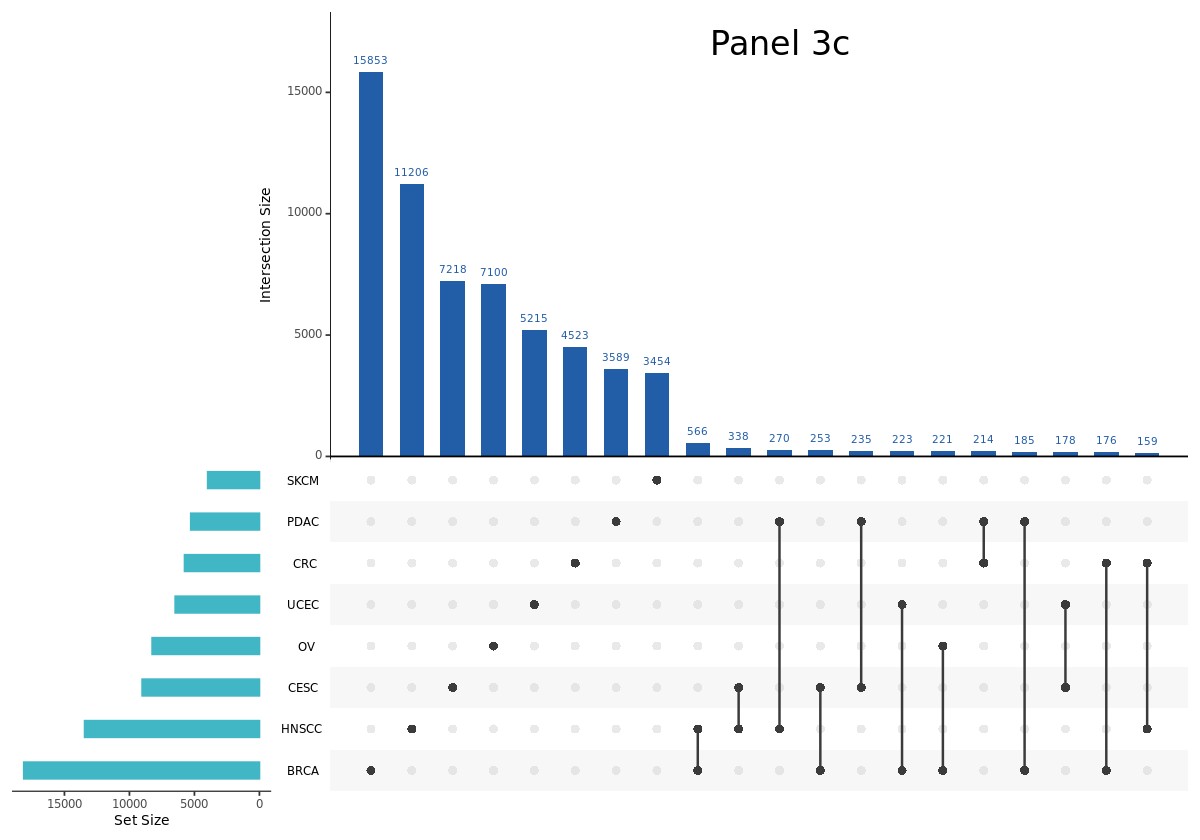

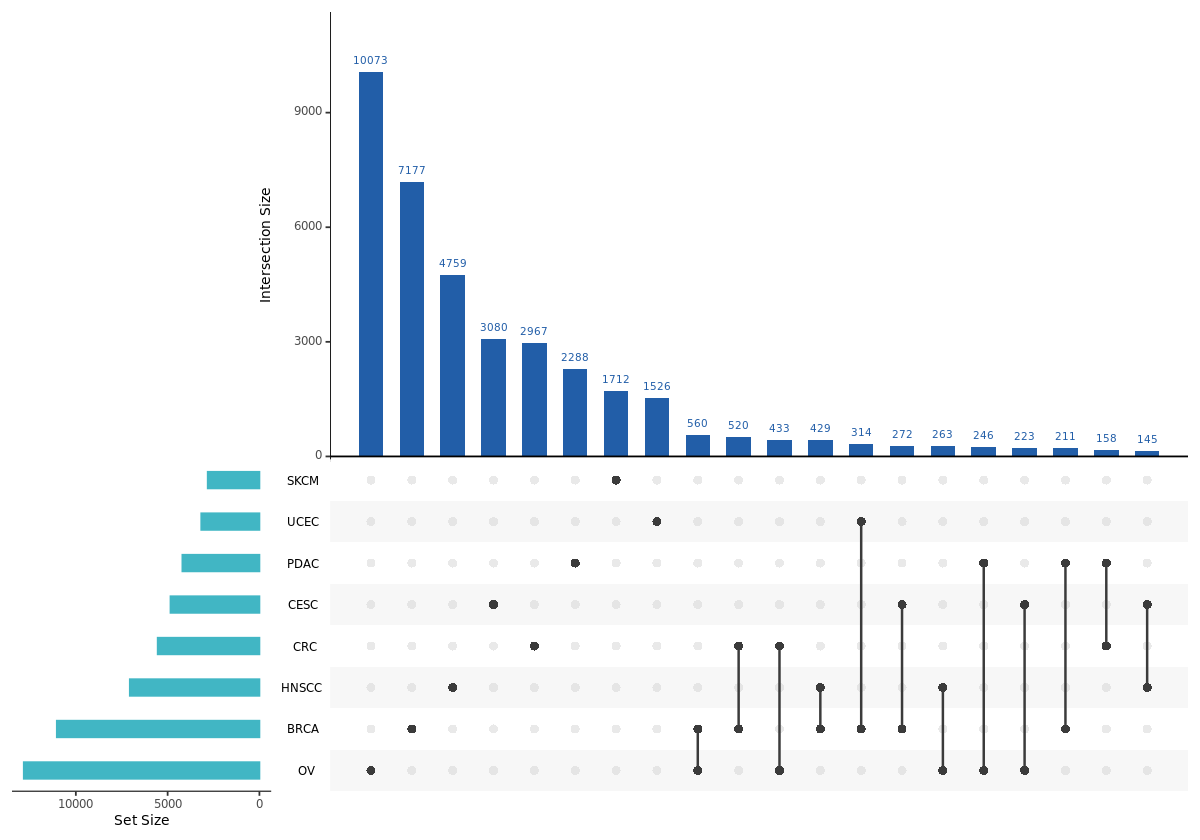

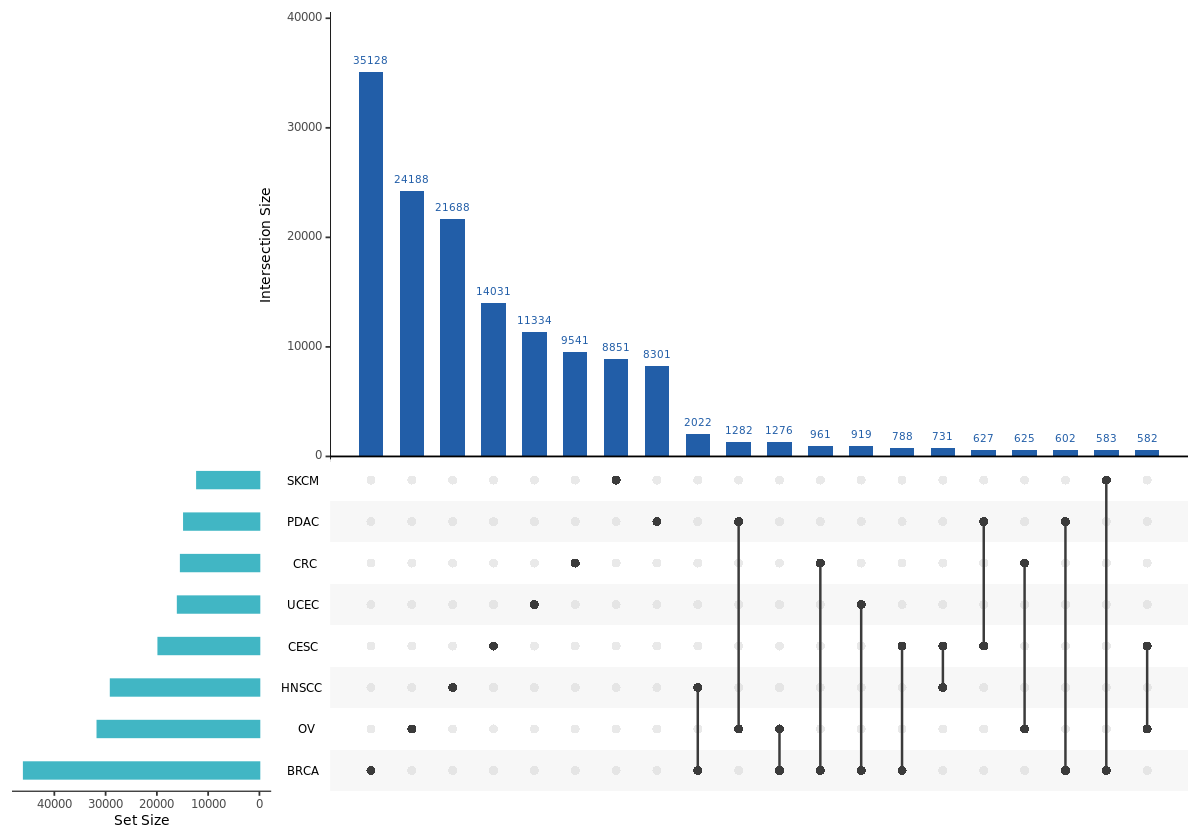

In [20]:
#this is panel 3c
all.links.list <- all.links %>% 
    filter(!(paste(gene, Cancer, sep ='_') %in% genes.gained)) %>% 
    filter(EpiMap.Annotation == 'Enhancer') %>%
    mutate(PeakGenePair = paste(peak, gene, sep = '-')) %>%
    dplyr::select (Cancer, PeakGenePair) %>% distinct() %>% with(split(PeakGenePair, Cancer))

plot <- upset( fromList(all.links.list), order.by = "freq", nintersects = 20, 
              main.bar.color ='#225ea8', sets.bar.color = '#41b6c4', mb.ratio = c(0.55, 0.45),
              sets = c( 'CESC', 'OV', 'UCEC','BRCA','PDAC', 'CRC', 'HNSCC', "SKCM"))
plot
grid.text("Panel 3c", x = 0.65, y = 0.95,
              gp = gpar(fontsize = 20))


all.links.list <- all.links %>% 
    filter(!(paste(gene, Cancer, sep ='_') %in% genes.gained)) %>% 
    filter(EpiMap.Annotation == 'Promoter') %>%
    mutate(PeakGenePair = paste(peak, gene, sep = '-')) %>%
    dplyr::select (Cancer, PeakGenePair) %>% with(split(PeakGenePair, Cancer))


plot <- upset( fromList(all.links.list), order.by = "freq", nintersects = 20, 
              main.bar.color ='#225ea8', sets.bar.color = '#41b6c4', mb.ratio = c(0.55, 0.45),
              sets = c( 'CESC', 'OV', 'UCEC','BRCA','PDAC', 'CRC', 'HNSCC', "SKCM"))
plot

all.links.list <- all.links %>% 
    mutate(PeakGenePair = paste(peak, gene, sep = '-')) %>%
    dplyr::select (Cancer, PeakGenePair) %>% distinct() %>% with(split(PeakGenePair, Cancer))
    
plot <- upset(fromList(all.links.list), order.by = "freq", nintersects = 20, 
              main.bar.color ='#225ea8', sets.bar.color = '#41b6c4', mb.ratio = c(0.55, 0.45),
              sets = c( 'CESC', 'OV', 'UCEC','BRCA','PDAC', 'CRC', 'HNSCC', 'SKCM'))
plot

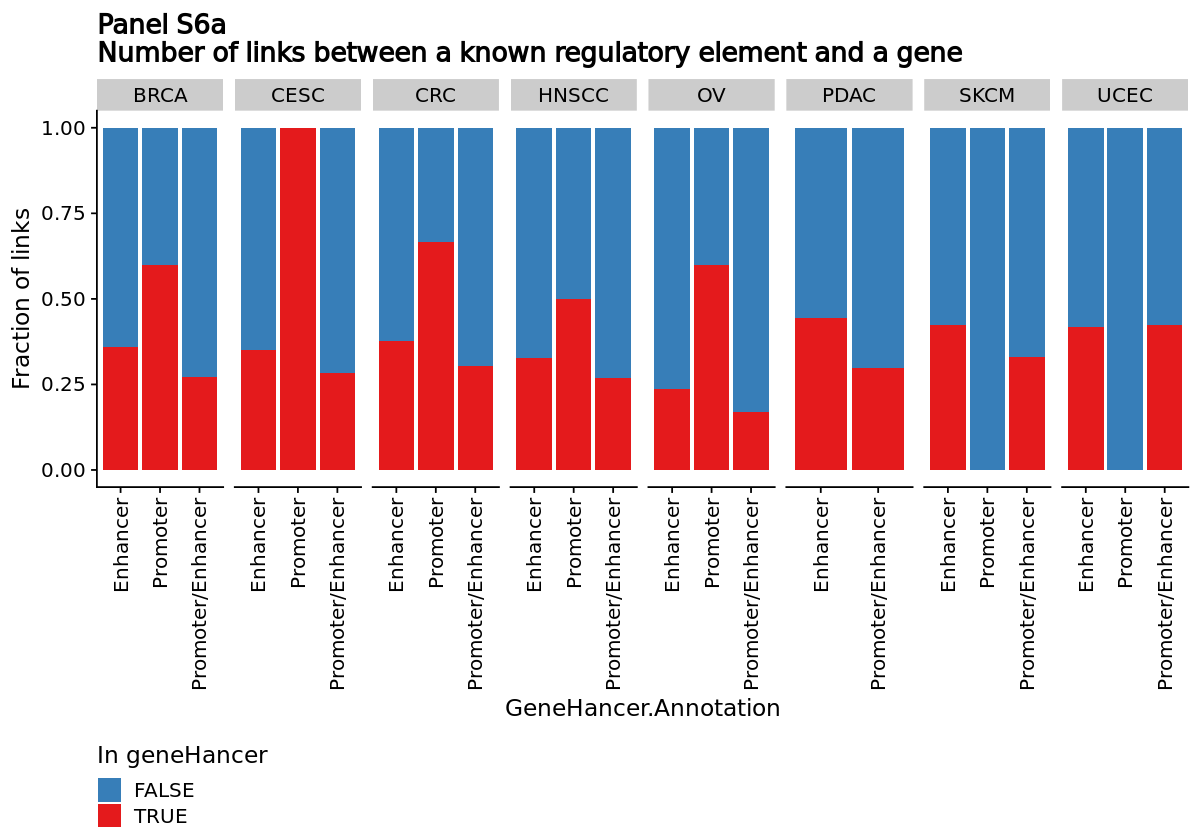

In [24]:

toplot <- all.links %>% filter((GeneHancer.Annotation!="")) %>% 
    filter(!(paste(gene, Cancer, sep ='_') %in% genes.gained))

toplot <- toplot %>% 
    dplyr::select(GeneHancer.Accession,Cancer, Enhancer_gene_pair, GeneHancer.Annotation, Enhancer_gene_pair.in.genehancerInter) %>% 
    distinct() %>%
    group_by(Enhancer_gene_pair.in.genehancerInter, GeneHancer.Annotation, Cancer) %>% 
    tally()


options(repr.plot.width=10, repr.plot.height=7)

ggplot(toplot, aes(x= GeneHancer.Annotation, y = n, fill = Enhancer_gene_pair.in.genehancerInter)) +
    geom_bar(stat = 'identity', position = 'fill') +
    facet_grid(~Cancer, scales = 'free') +
    scale_fill_manual (values = c('#377eb8','#e41a1c'), name = 'In geneHancer') +
    cowplot::theme_cowplot() +
    ylab('Fraction of links') +
    theme(legend.position="bottom", 
            axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5),
         legend.direction = "vertical") +
    ggtitle('Panel S6a\nNumber of links between a known regulatory element and a gene')



